In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [142]:
calls = pd.read_csv('/content/drive/MyDrive/Skyhack/callsf0d4f5a.csv')
customers = pd.read_csv('/content/drive/MyDrive/Skyhack/customers2afd6ea.csv')
sentiment = pd.read_csv('/content/drive/MyDrive/Skyhack/sentiment_statisticscc1e57a.csv')
reason = pd.read_csv('/content/drive/MyDrive/Skyhack/reason18315ff.csv')

In [143]:
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'], format='%m/%d/%Y %H:%M')
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'], format='%m/%d/%Y %H:%M')
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'], format='%m/%d/%Y %H:%M')

In [144]:
calls['total_call_time'] = (calls['call_end_datetime'] - calls['call_start_datetime']).dt.total_seconds()
calls['time_waited'] = (calls['agent_assigned_datetime'] - calls['call_start_datetime']).dt.total_seconds()
calls['time_to_resolve'] = (calls['call_end_datetime'] - calls['agent_assigned_datetime']).dt.total_seconds()

# **Calculating AHT and AST**

In [145]:
total_calls = calls.shape[0]
total_handle_time = calls['time_to_resolve'].sum()
total_waiting_time = calls['time_waited'].sum()

AHT = total_handle_time / total_calls
AST = total_waiting_time / total_calls
print('Overall AHT = ',AHT)
print('Overall AST = ',AST)

Overall AHT =  697.0486004734717
Overall AST =  437.0675393399248


merging calls dataset with customers dataset

In [146]:
calls_with_customer = pd.merge(calls, customers, on='customer_id', how='left')

merging calls_with_customer to sentiment dataset

In [147]:
call_sentiment = pd.merge(calls_with_customer, sentiment, on='call_id', how='left')

In [148]:
call_sentiment.drop('agent_id_y', axis=1, inplace=True)
call_sentiment.rename(columns={'agent_id_x': 'agent_id'}, inplace=True)

# **Important Data**

In [149]:
imp_data = call_sentiment[['call_id', 'customer_id', 'agent_id', 'elite_level_code', 'total_call_time', 'time_waited', 'time_to_resolve', 'agent_tone', 'customer_tone', 'average_sentiment', 'silence_percent_average']]

#### Merging reasons

In [150]:
imp_data = pd.merge(imp_data, reason, on='call_id', how='left')

In [151]:
imp_data['primary_call_reason'].fillna('Other Topics', inplace=True)
imp_data['total_call_time'] = pd.to_numeric(imp_data['total_call_time'], errors='coerce')
imp_data['time_waited'] = pd.to_numeric(imp_data['time_waited'], errors='coerce')
imp_data['time_to_resolve'] = pd.to_numeric(imp_data['time_to_resolve'], errors='coerce')

<ipython-input-151-5c58a6285280>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





cleaning reasons data

In [152]:
imp_data['primary_call_reason'] = imp_data['primary_call_reason'].str.strip().str.lower()
imp_data['primary_call_reason'] = imp_data['primary_call_reason'].str.replace(r'\s+', ' ', regex=True)
standard_reasons = {
    'products & services': 'products and services',
    'post flight': 'post-flight',
    'check in': 'check-in',
    'mileage plus': 'mileage plus',
    'digital support': 'digital support',
    'voluntary change': 'voluntary change',
    'voluntary cancel': 'voluntary cancel',
    'traveler updates': 'traveler updates',
    'other topics': 'other topics',
    'irrops': 'irrops',
    'seating': 'seating',
    'unaccompanied minor': 'unaccompanied minor',
    'schedule change': 'schedule change',
    'baggage': 'baggage',
    'communications': 'communications',
    'booking': 'booking',
    'etc': 'etc',
    'disability': 'disability',
}

imp_data['primary_call_reason'] = imp_data['primary_call_reason'].replace(standard_reasons)

In [153]:
imp_data

,call_id,customer_id,agent_id,elite_level_code,total_call_time,time_waited,time_to_resolve,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason
0,4667960400,2033123310,963118,4.0,2280.0,420.0,1860.0,neutral,angry,-0.04,0.39,voluntary cancel
1,1122072124,8186702651,519057,NaN,900.0,180.0,720.0,calm,neutral,0.02,0.35,booking
2,6834291559,2416856629,158319,NaN,1620.0,480.0,1140.0,neutral,polite,-0.13,0.32,irrops
3,2266439882,1154544516,488324,2.0,720.0,300.0,420.0,neutral,frustrated,-0.20,0.20,upgrade
4,1211603231,5214456437,721730,0.0,1140.0,600.0,540.0,neutral,polite,-0.05,0.35,seating
...,...,...,...,...,...,...,...,...,...,...,...,...
71805,1563273072,8022667294,413148,NaN,2220.0,540.0,1680.0,calm,calm,0.05,0.34,post-flight
71806,8865997781,4474867021,980156,1.0,660.0,180.0,480.0,calm,frustrated,0.03,0.22,upgrade
71807,8019240181,9762042472,616988,NaN,720.0,360.0,360.0,calm,polite,0.05,0.42,upgrade
71808,8332067080,8095620266,161354,1.0,600.0,360.0,240.0,neutral,polite,-0.07,0.13,other topics


In [154]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pivot_data = imp_data.pivot_table(index='agent_tone', columns='customer_tone', values='time_to_resolve', aggfunc='mean').astype(int)

fig = go.Figure(data=go.Heatmap(
    z=pivot_data.values,
    x=pivot_data.columns,
    y=pivot_data.index,
    colorscale='Blues',
    text=pivot_data.values,
    hoverinfo='text',
    showscale=True,
    texttemplate="%{text}",
))

fig.update_layout(
    title="Average Handle Time by Agent and Customer Tone",
    xaxis_title="Customer Tone",
    yaxis_title="Agent Tone",
    width=800,
    height=800,
)

fig.show()


In [155]:
pivot_data = imp_data.pivot_table(index='agent_tone', columns='customer_tone', values='total_call_time', aggfunc='mean').astype(int)

fig = go.Figure(data=go.Heatmap(
    z=pivot_data.values,
    x=pivot_data.columns,
    y=pivot_data.index,
    colorscale='Blues',
    text=pivot_data.values,
    hoverinfo='text',
    showscale=True,
    texttemplate="%{text}",
))

fig.update_layout(
    title="Avg Total Call Time by Agent and Customer Tone",
    xaxis_title="Customer Tone",
    yaxis_title="Agent Tone",
    width=800,
    height=800,
)

fig.show()


<Axes: xlabel='average_sentiment', ylabel='time_to_resolve'>

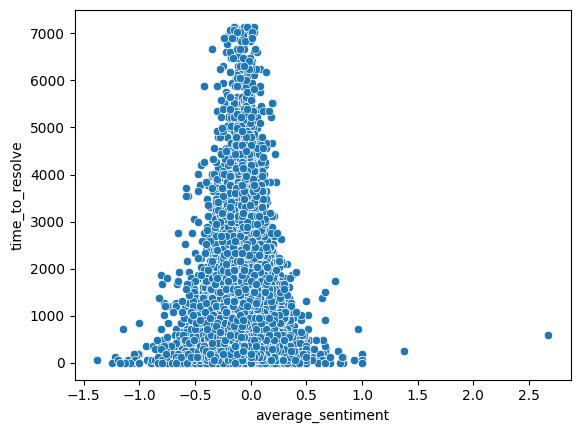

In [156]:
sns.scatterplot(data=imp_data, x='average_sentiment', y='time_to_resolve')

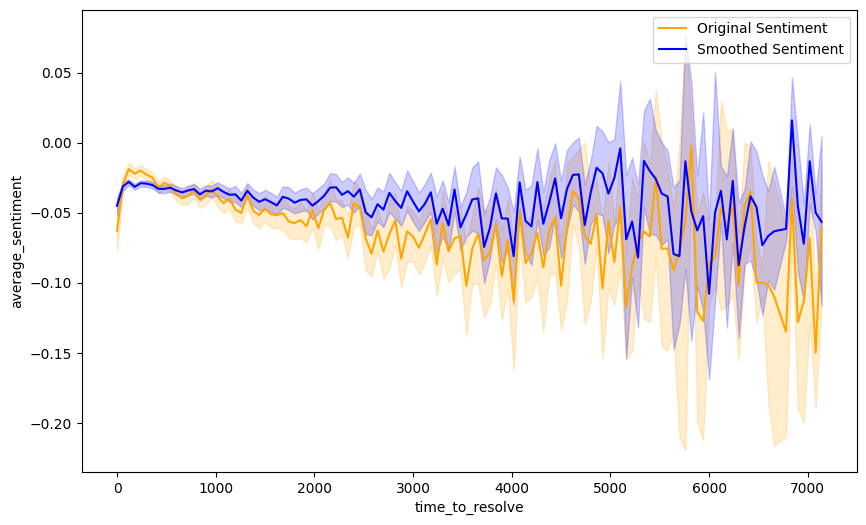

In [157]:
imp_data['moving_avg_sentiment'] = imp_data['average_sentiment'].rolling(window=3).mean()

plt.figure(figsize=(10, 6))

sns.lineplot(x='time_to_resolve', y='average_sentiment', data=imp_data, label='Original Sentiment', color='orange')
sns.lineplot(x='time_to_resolve', y='moving_avg_sentiment', data=imp_data, label='Smoothed Sentiment', color='blue')
plt.legend()
plt.show()

#Reason Analysis

In [158]:
reason_count = imp_data['primary_call_reason'].value_counts()
reason_time = imp_data.groupby('primary_call_reason').mean(numeric_only=True)[['total_call_time', 'time_waited', 'time_to_resolve','silence_percent_average','average_sentiment']].reset_index()

In [159]:
reason_time = pd.merge(reason_time, reason_count, on='primary_call_reason', how='left')

In [160]:
reason_time.sort_values(by='count', ascending=False, inplace=True)

In [161]:
reason_time

,primary_call_reason,total_call_time,time_waited,time_to_resolve,silence_percent_average,average_sentiment,count
8,irrops,1145.197205,360.081136,785.116069,0.309404,-0.074065,13311
19,voluntary change,1179.640487,540.486726,639.153761,0.289599,-0.003826,10848
14,seating,1045.819324,570.824823,474.994501,0.264613,-0.002770,6365
10,other topics,1059.102929,410.982427,648.120502,0.284537,-0.028240,5975
9,mileage plus,1356.588617,361.015211,995.573406,0.275038,-0.027398,5851
11,post-flight,1502.327945,569.431871,932.896074,0.297804,-0.063914,4330
4,communications,1066.687500,239.968750,826.718750,0.303578,-0.036392,3840
12,products and services,1049.009604,302.448980,746.560624,0.276759,-0.034430,3332
0,baggage,875.741525,542.097458,333.644068,0.250508,-0.019681,2832
17,upgrade,930.832725,298.487947,632.344777,0.277023,-0.016007,2738


In [198]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_to_resolve'],
           name='Average Handling Time', opacity=0.7),
    secondary_y=False)

fig.add_trace(
    go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['count'],
               mode='lines+markers', name='Number of Calls',
               line=dict(color='orange')),
    secondary_y=True)

fig.update_layout(
    title='AHT and Number of Calls by Call Reason',
    xaxis_title='Call Reason',
    yaxis_title='Average Handling Time',
    width=680,
    height=400)


fig.update_yaxes(title_text='Number of Calls', secondary_y=True)
fig.update_xaxes(tickangle=45)
fig.show()


In [199]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_to_resolve'],
           name='Average Handling Time', opacity=0.7),
    secondary_y=False)

fig.add_trace(
    go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['silence_percent_average'],
               mode='lines+markers', name='Average Silence',
               line=dict(color='orange')),
    secondary_y=True)

fig.update_layout(
    title='AHT and Percent Silence by Call Reason',
    xaxis_title='Call Reason',
    yaxis_title='Average Handling Time',
    width=680,
    height=400)


fig.update_yaxes(title_text='Number of Calls', secondary_y=True)
fig.update_xaxes(tickangle=45)
fig.show()


In [164]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_to_resolve'],
           name='Average Handling Time', opacity=0.7),
    secondary_y=False)

fig.add_trace(
    go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['average_sentiment'],
               mode='lines+markers', name='Average sentiment',
               line=dict(color='orange')),
    secondary_y=True)

fig.update_layout(
    title='AHT and Average Sentiment by Call Reason',
    xaxis_title='Call Reason',
    yaxis_title='Average Handling Time',
    width=1280,
    height=400)


fig.update_yaxes(title_text='Number of Calls', secondary_y=True)
fig.update_xaxes(tickangle=45)
fig.show()


In [165]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_waited'],
           name='Call Wait Time', opacity=0.7),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['count'],
               mode='lines+markers', name='Number of Calls',
               line=dict(color='orange')),
    secondary_y=True,
)

fig.update_layout(
    title='AST and Number of Calls by Call Reason',
    xaxis_title='Call Reason',
    yaxis_title='Call Wait Time',
    width=1280,
    height=400,
)

fig.update_yaxes(title_text='Number of Calls', secondary_y=True)

fig.update_xaxes(tickangle=45)

fig.show()


In [166]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_waited'],
           name='Call Wait Time', opacity=0.7),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['silence_percent_average'],
               mode='lines+markers', name='Average Silence',
               line=dict(color='orange')),
    secondary_y=True,
)

fig.update_layout(
    title='AST and Average Silence by Call Reason',
    xaxis_title='Call Reason',
    yaxis_title='Call Wait Time',
    width=1280,
    height=400,
)

fig.update_yaxes(title_text='Average Silence', secondary_y=True)

fig.update_xaxes(tickangle=45)

fig.show()


In [167]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_waited'],
           name='Call Wait Time', opacity=0.7),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['average_sentiment'],
               mode='lines+markers', name='Average Sentiment',
               line=dict(color='orange')),
    secondary_y=True,
)

fig.update_layout(
    title='AST and Average Sentimen by Call Reason',
    xaxis_title='Call Reason',
    yaxis_title='Call Wait Time',
    width=1280,
    height=400,
)

fig.update_yaxes(title_text='Average Sentimen', secondary_y=True)

fig.update_xaxes(tickangle=45)

fig.show()


In [168]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'AHT and Number of Calls',
        'AHT and Percent Silence',
        'AHT and Average Sentiment',
        'AST and Number of Calls',
        'AST and Average Silence',
        'AST and Average Sentiment'),
    specs=[[{"secondary_y": True}, {"secondary_y": True}],
           [{"secondary_y": True}, {"secondary_y": True}],
           [{"secondary_y": True}, {"secondary_y": True}]],
    vertical_spacing=0.15
)

fig.add_trace(go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_to_resolve'],
                     name='Average Handling Time', opacity=0.7),
              row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['count'],
                         mode='lines+markers', name='Number of Calls', line=dict(color='orange')),
              row=1, col=1, secondary_y=True)

fig.add_trace(go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_to_resolve'],
                     name='Average Handling Time', opacity=0.7),
              row=1, col=2, secondary_y=False)
fig.add_trace(go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['silence_percent_average'],
                         mode='lines+markers', name='Average Silence', line=dict(color='orange')),
              row=1, col=2, secondary_y=True)

fig.add_trace(go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_to_resolve'],
                     name='Average Handling Time', opacity=0.7),
              row=2, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['average_sentiment'],
                         mode='lines+markers', name='Average Sentiment', line=dict(color='orange')),
              row=2, col=1, secondary_y=True)

fig.add_trace(go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_waited'],
                     name='Call Wait Time', opacity=0.7),
              row=2, col=2, secondary_y=False)
fig.add_trace(go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['count'],
                         mode='lines+markers', name='Number of Calls', line=dict(color='orange')),
              row=2, col=2, secondary_y=True)

fig.add_trace(go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_waited'],
                     name='Call Wait Time', opacity=0.7),
              row=3, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['silence_percent_average'],
                         mode='lines+markers', name='Average Silence', line=dict(color='orange')),
              row=3, col=1, secondary_y=True)

fig.add_trace(go.Bar(x=reason_time['primary_call_reason'], y=reason_time['time_waited'],
                     name='Call Wait Time', opacity=0.7),
              row=3, col=2, secondary_y=False)
fig.add_trace(go.Scatter(x=reason_time['primary_call_reason'], y=reason_time['average_sentiment'],
                         mode='lines+markers', name='Average Sentiment', line=dict(color='orange')),
              row=3, col=2, secondary_y=True)

fig.update_layout(
    height=1200,
    width=1000,
    title_text="Comparison of Handling Time, Silence, Sentiment, and Call Metrics",
    showlegend=False,
)

fig.update_xaxes(tickangle=45, row=1, col=1)
fig.update_xaxes(tickangle=45, row=1, col=2)
fig.update_xaxes(tickangle=45, row=2, col=1)
fig.update_xaxes(tickangle=45, row=2, col=2)
fig.update_xaxes(tickangle=45, row=3, col=1)
fig.update_xaxes(tickangle=45, row=3, col=2)

fig.update_yaxes(title_text="Number of Calls", secondary_y=True, row=1, col=1)
fig.update_yaxes(title_text="Average Silence", secondary_y=True, row=1, col=2)
fig.update_yaxes(title_text="Average Sentiment", secondary_y=True, row=2, col=1)
fig.update_yaxes(title_text="Number of Calls", secondary_y=True, row=2, col=2)
fig.update_yaxes(title_text="Average Silence", secondary_y=True, row=3, col=1)
fig.update_yaxes(title_text="Average Sentiment", secondary_y=True, row=3, col=2)

fig.show()


In [169]:
fig = px.pie(reason_time, values='count', names='primary_call_reason', title='Call Reasons')
fig.update_layout(
    width=500,
    height=400,
    margin=dict(l=20, r=20, t=40, b=20) )
fig.show()

## Percent difference in most and least frequent call reasons

In [170]:
#IRROPS
irrops_data = imp_data[imp_data['primary_call_reason'] == 'irrops']
irrops_calls = irrops_data.shape[0]
total_irrops_time = irrops_data['time_to_resolve'].sum()
irrops_aht = total_irrops_time / irrops_calls
irrops_aht

785.1160694162722

In [171]:
#unaccopained_minor
unaccopained_minor_data = imp_data[imp_data['primary_call_reason'] == 'unaccompanied minor']
unaccopained_minor_calls = unaccopained_minor_data.shape[0]
total_unaccopained_minor_time = unaccopained_minor_data['time_to_resolve'].sum()
unaccopained_minor_aht = total_unaccopained_minor_time / unaccopained_minor_calls
unaccopained_minor_aht

519.2307692307693

In [172]:
#aht percent difference between most and least frequent call reasons
aht_diff = (irrops_aht - unaccopained_minor_aht) / irrops_aht * 100
aht_diff

33.86573151956839

#Silence Time

In [173]:
imp_data['silence_percent_average'] = pd.to_numeric(imp_data['silence_percent_average'], errors='coerce')

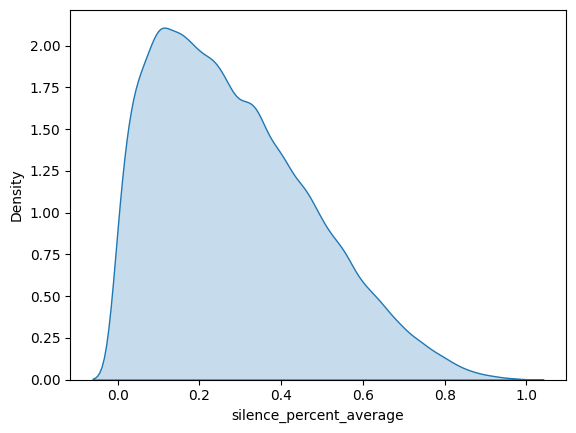

In [174]:
sns.kdeplot(imp_data['silence_percent_average'], fill=True)
plt.show()

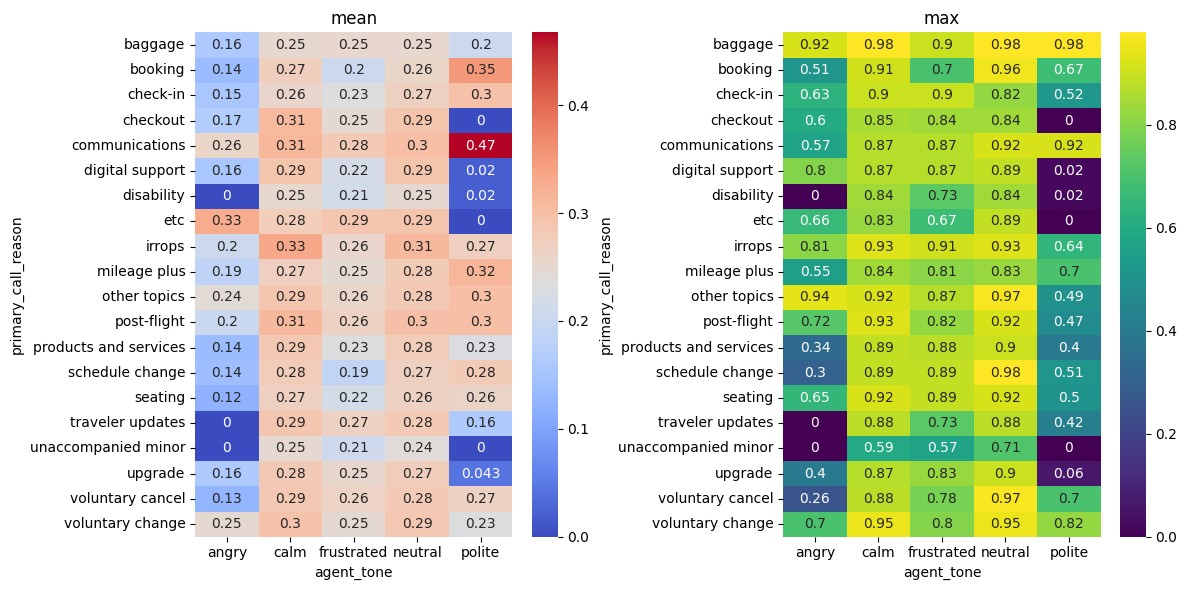

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(imp_data.pivot_table(index='primary_call_reason', columns='agent_tone', values='silence_percent_average', aggfunc='mean', fill_value=0), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('mean')
sns.heatmap(imp_data.pivot_table(index='primary_call_reason', columns='agent_tone', values='silence_percent_average', aggfunc='max', fill_value=0), annot=True, cmap='viridis', ax=axes[1])
axes[1].set_title('max')
plt.tight_layout()
plt.show()

<Axes: xlabel='time_to_resolve', ylabel='silence_percent_average'>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



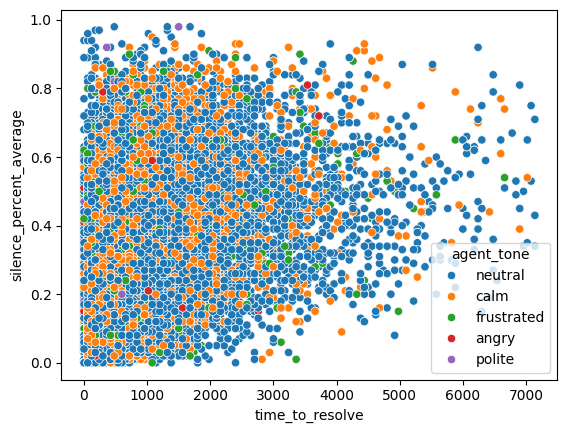

In [176]:
sns.scatterplot(data=imp_data, x='time_to_resolve', y='silence_percent_average', hue='agent_tone')

#Agents

creating agents data

In [177]:
agent_data = imp_data.groupby('agent_id').mean(numeric_only=True)[['total_call_time', 'time_waited', 'time_to_resolve','silence_percent_average']].sort_values(by='total_call_time', ascending=False)
agent_freq = imp_data.groupby('agent_id')['primary_call_reason'] .agg(lambda x: x.value_counts().idxmax())
agent_aht_ast = imp_data.groupby('agent_id').agg({'total_call_time':'sum', 'time_waited':'sum', 'time_to_resolve':'count'})

In [178]:
agent_data = pd.merge(agent_data, agent_freq, on='agent_id', how='left')
agent_data = pd.merge(agent_data, agent_aht_ast, on='agent_id', how='left')

agent_data.rename(columns={'total_call_time_x':'total_call_time', 'time_waited_x':'AST', 'time_to_resolve_x':'AHT'},inplace=True)

agent_data.drop(['total_call_time_y', 'time_waited_y', 'time_to_resolve_y'], axis=1, inplace=True)

In [179]:
agent_data.reset_index(inplace=True)
agent_data.reset_index(inplace=True)

In [180]:
agent_data

,index,agent_id,total_call_time,AST,AHT,silence_percent_average,primary_call_reason
0,0,102574,4080.0,480.000000,3600.000000,0.260000,irrops
1,1,506130,3300.0,420.000000,2880.000000,0.390000,voluntary cancel
2,2,140146,2980.0,360.000000,2620.000000,0.420000,mileage plus
3,3,255256,2900.0,280.000000,2620.000000,0.443333,products and services
4,4,558705,2400.0,420.000000,1980.000000,0.180000,irrops
...,...,...,...,...,...,...,...
378,378,676262,840.0,450.000000,390.000000,0.186250,irrops
379,379,161354,780.0,420.000000,360.000000,0.315000,baggage
380,380,547592,780.0,600.000000,180.000000,0.100000,digital support
381,381,229129,760.0,386.666667,373.333333,0.241111,communications


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



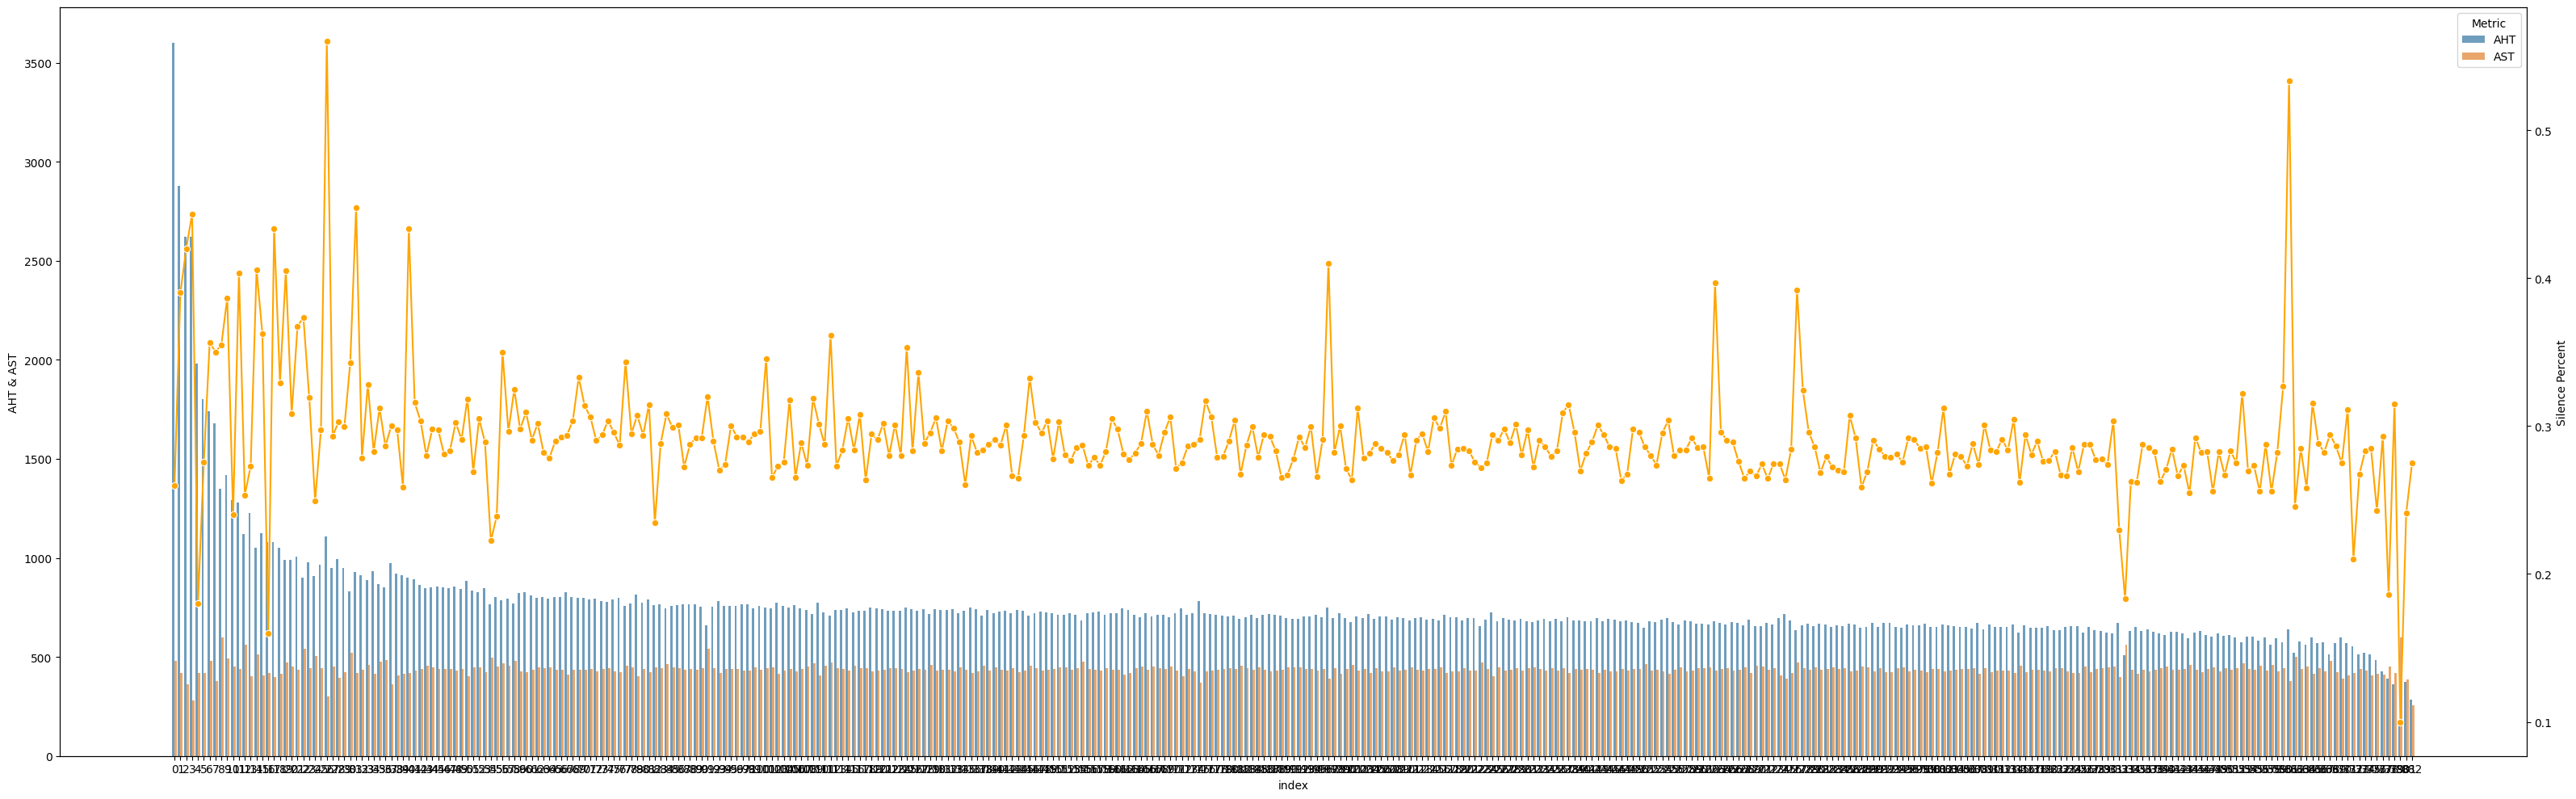

In [181]:
melted_data = agent_data.melt(id_vars=['index'], value_vars=['AHT', 'AST'],
                              var_name='Metric', value_name='Value')


plt.figure(figsize=(32, 10))
ax1 = sns.barplot(data=melted_data, x='index', y='Value', hue='Metric', alpha=0.7)

ax2 = plt.gca().twinx()
sns.lineplot(data=agent_data, x='index', y='silence_percent_average', marker='o', color='orange', ax=ax2)

plt.xlabel('Agent ID')
ax1.set_ylabel('AHT & AST')
ax2.set_ylabel('Silence Percent')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [182]:
agent_aht_ast.drop(['total_call_time','time_waited'], axis=1, inplace=True)
agent_data = pd.merge(agent_data, agent_aht_ast, on='agent_id', how='left')
agent_data.rename(columns={'time_to_resolve': 'count'}, inplace=True)
agent_data

,index,agent_id,total_call_time,AST,AHT,silence_percent_average,primary_call_reason,count
0,0,102574,4080.0,480.000000,3600.000000,0.260000,irrops,2
1,1,506130,3300.0,420.000000,2880.000000,0.390000,voluntary cancel,1
2,2,140146,2980.0,360.000000,2620.000000,0.420000,mileage plus,3
3,3,255256,2900.0,280.000000,2620.000000,0.443333,products and services,3
4,4,558705,2400.0,420.000000,1980.000000,0.180000,irrops,2
...,...,...,...,...,...,...,...,...
378,378,676262,840.0,450.000000,390.000000,0.186250,irrops,8
379,379,161354,780.0,420.000000,360.000000,0.315000,baggage,2
380,380,547592,780.0,600.000000,180.000000,0.100000,digital support,1
381,381,229129,760.0,386.666667,373.333333,0.241111,communications,9


In [183]:
agent_tone_freq = imp_data.groupby('agent_id')['agent_tone'] .agg(lambda x: x.value_counts().idxmax())
agent_data = agent_data.merge(agent_tone_freq, on='agent_id', how='left')
agent_sentiment = imp_data.groupby('agent_id').mean(numeric_only=True)[['average_sentiment']]
agent_data = agent_data.merge(agent_sentiment, on='agent_id', how='left')

Creating data with top 50 agents by calls picked and bottom 50 by calls picked

In [184]:
top_agent_data = pd.concat([agent_data.sort_values(by='count', ascending=False).head(50),agent_data.sort_values(by='count', ascending=False).tail(50)]).reset_index()
top_agent_data.drop('index', axis=1, inplace=True)
top_agent_data.reset_index(inplace=True)
top_agent_data

,index,level_0,agent_id,total_call_time,AST,AHT,silence_percent_average,primary_call_reason,count,agent_tone,average_sentiment
0,0,338,251287,1064.320988,436.543210,627.777778,0.282778,irrops,486,neutral,-0.036543
1,1,334,594957,1069.272349,436.340956,632.931393,0.262599,irrops,481,neutral,-0.048938
2,2,305,963118,1088.280255,438.471338,649.808917,0.279427,irrops,471,neutral,-0.050149
3,3,298,757349,1092.913043,432.652174,660.260870,0.284870,irrops,460,neutral,-0.031978
4,4,339,376343,1062.610619,444.292035,618.318584,0.262323,irrops,452,neutral,-0.029268
...,...,...,...,...,...,...,...,...,...,...,...
95,95,26,980156,1410.000000,300.000000,1110.000000,0.560000,products and services,2,neutral,0.015000
96,96,91,771538,1200.000000,540.000000,660.000000,0.320000,voluntary change,2,neutral,-0.085000
97,97,0,102574,4080.000000,480.000000,3600.000000,0.260000,irrops,2,neutral,-0.075000
98,98,1,506130,3300.000000,420.000000,2880.000000,0.390000,voluntary cancel,1,neutral,-0.030000


<Axes: xlabel='index', ylabel='AHT'>

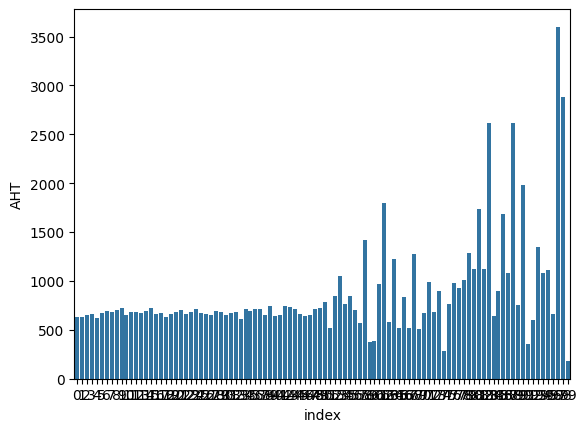

In [185]:
sns.barplot(data=top_agent_data, x='index', y='AHT')

In [186]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=top_agent_data['index'][:50],
    y=top_agent_data['average_sentiment'][:50],
    mode='lines+markers',
    name='Top 50 Agents',
    line=dict(color='blue'),
    marker=dict(symbol='circle', size=8)))

fig.add_trace(go.Scatter(
    x=top_agent_data['index'][-50:],
    y=top_agent_data['average_sentiment'][-50:],
    mode='lines+markers',
    name='Least 50 Agents',
    line=dict(color='orange'),
    marker=dict(symbol='circle', size=8)))
fig.update_layout(
    title='Graph Depicting Average Sentiment of Top 50 Agents with Most Calls Received and Least 50 Agents',
    xaxis_title='Agents',
    yaxis_title='Average Sentiment',
    width=700,
    height=400)
fig.show()

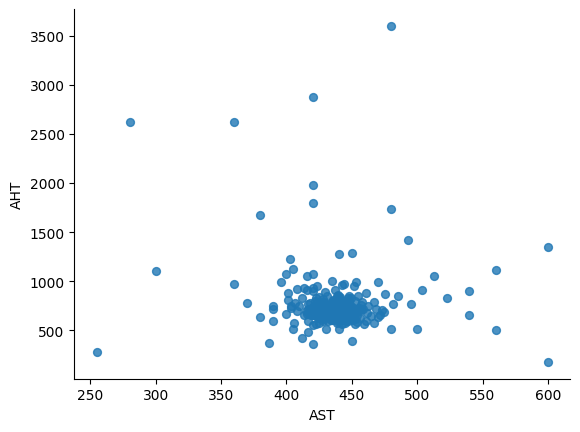

In [187]:
sorted_agent_data = agent_data.sort_values(by='count', ascending=False)
sorted_agent_data.plot(kind='scatter', x='AST', y='AHT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [188]:
sorted_agent_data

,index,agent_id,total_call_time,AST,AHT,silence_percent_average,primary_call_reason,count,agent_tone,average_sentiment
338,338,251287,1064.320988,436.543210,627.777778,0.282778,irrops,486,neutral,-0.036543
334,334,594957,1069.272349,436.340956,632.931393,0.262599,irrops,481,neutral,-0.048938
305,305,963118,1088.280255,438.471338,649.808917,0.279427,irrops,471,neutral,-0.050149
298,298,757349,1092.913043,432.652174,660.260870,0.284870,irrops,460,neutral,-0.031978
339,339,376343,1062.610619,444.292035,618.318584,0.262323,irrops,452,neutral,-0.029268
...,...,...,...,...,...,...,...,...,...,...
26,26,980156,1410.000000,300.000000,1110.000000,0.560000,products and services,2,neutral,0.015000
91,91,771538,1200.000000,540.000000,660.000000,0.320000,voluntary change,2,neutral,-0.085000
0,0,102574,4080.000000,480.000000,3600.000000,0.260000,irrops,2,neutral,-0.075000
1,1,506130,3300.000000,420.000000,2880.000000,0.390000,voluntary cancel,1,neutral,-0.030000


In [189]:
bins = range(0, sorted_agent_data['count'].max() + 5, 5)
sorted_agent_data['calls_bins'] = pd.cut(sorted_agent_data['count'], bins=bins)

sorted_agent_data['calls_bins'] = sorted_agent_data['calls_bins'].astype(str)

hist_data = sorted_agent_data['calls_bins'].value_counts().sort_index().reset_index()
hist_data.columns = ['calls_bins', 'num_agents']

fig = px.bar(
    hist_data,
    x='calls_bins',
    y='num_agents',
    title='Distribution of Agents by Number of Calls Picked',
    labels={'calls_bins': 'Number of Calls Picked (in blocks of 5)', 'num_agents': 'Number of Agents'},
    opacity=0.7)

fig.update_layout(
    xaxis_title='Number of Calls Picked (in blocks of 5)',
    yaxis_title='Number of Agents',
    xaxis=dict(tickangle=45),
    width=1000,
    height=400)
fig.show()

#Time Analysis

In [190]:
time_data = calls[['call_id','agent_id', 'customer_id', 'call_start_datetime','agent_assigned_datetime']]

time_data = pd.merge(time_data, sentiment, on='call_id', how='left')
time_data = pd.merge(time_data, reason, on='call_id', how='left')

time_data['call_start_datetime'] = pd.to_datetime(time_data['call_start_datetime'], format='%m/%d/%Y %H:%M')
time_data['agent_assigned_datetime'] = pd.to_datetime(time_data['agent_assigned_datetime'], format='%m/%d/%Y %H:%M')

time_data['call_in_time'] = time_data['call_start_datetime'].dt.strftime('%H:%M')
time_data['agent_pick_time'] = time_data['agent_assigned_datetime'].dt.strftime('%H:%M')
time_data

,call_id,agent_id_x,customer_id,call_start_datetime,agent_assigned_datetime,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason,call_in_time,agent_pick_time
0,4667960400,963118,2033123310,2024-07-31 23:56:00,2024-08-01 00:03:00,963118,neutral,angry,-0.04,0.39,Voluntary Cancel,23:56,00:03
1,1122072124,519057,8186702651,2024-08-01 00:03:00,2024-08-01 00:06:00,519057,calm,neutral,0.02,0.35,Booking,00:03,00:06
2,6834291559,158319,2416856629,2024-07-31 23:59:00,2024-08-01 00:07:00,158319,neutral,polite,-0.13,0.32,IRROPS,23:59,00:07
3,2266439882,488324,1154544516,2024-08-01 00:05:00,2024-08-01 00:10:00,488324,neutral,frustrated,-0.20,0.20,Upgrade,00:05,00:10
4,1211603231,721730,5214456437,2024-08-01 00:04:00,2024-08-01 00:14:00,721730,neutral,polite,-0.05,0.35,Seating,00:04,00:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71805,1563273072,413148,8022667294,2024-08-31 23:48:00,2024-08-31 23:57:00,413148,calm,calm,0.05,0.34,Post Flight,23:48,23:57
71806,8865997781,980156,4474867021,2024-08-31 23:55:00,2024-08-31 23:58:00,980156,calm,frustrated,0.03,0.22,Upgrade,23:55,23:58
71807,8019240181,616988,9762042472,2024-08-31 23:52:00,2024-08-31 23:58:00,616988,calm,polite,0.05,0.42,Upgrade,23:52,23:58
71808,8332067080,161354,8095620266,2024-08-31 23:53:00,2024-08-31 23:59:00,161354,neutral,polite,-0.07,0.13,NaN,23:53,23:59


In [191]:
time_data['primary_call_reason'].fillna('Other Topics', inplace=True)
time_data['primary_call_reason'] = imp_data['primary_call_reason'].str.strip().str.lower()
time_data['primary_call_reason'] = imp_data['primary_call_reason'].str.replace(r'\s+', ' ', regex=True)

time_data['primary_call_reason'] = imp_data['primary_call_reason'].replace(standard_reasons)

<ipython-input-191-4489d875f20e>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





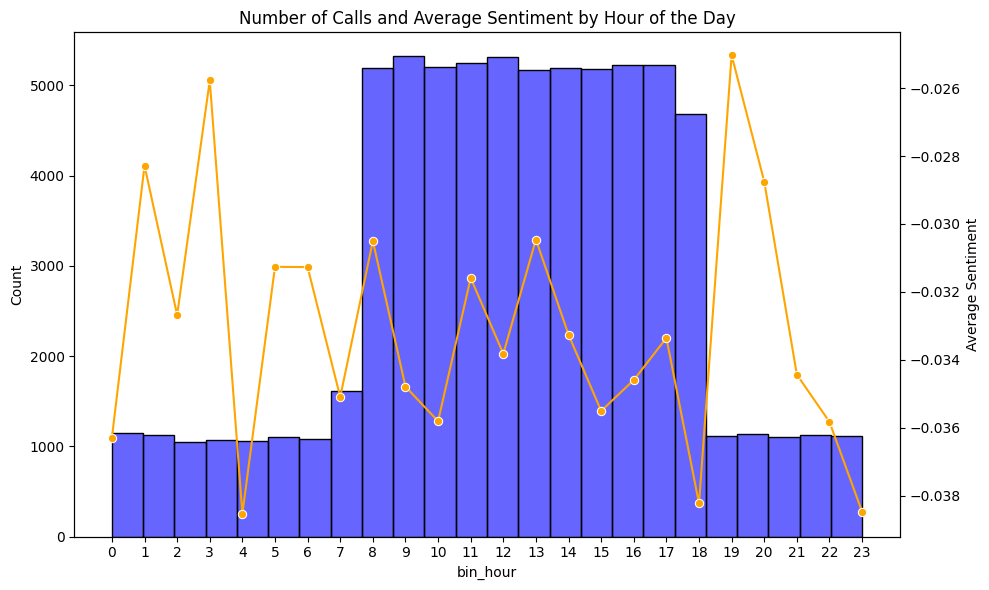

In [192]:
time_data['bin_hour'] = time_data['call_start_datetime'].dt.hour

avg_sentiment_by_hour = time_data.groupby('bin_hour')['average_sentiment'].mean()

plt.figure(figsize=(10, 6))

sns.histplot(time_data['bin_hour'], bins=24, kde=False, color='blue', alpha=0.6)

ax2 = plt.gca().twinx()

sns.lineplot(x=avg_sentiment_by_hour.index, y=avg_sentiment_by_hour.values, color='orange', marker='o', ax=ax2)

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Calls')
ax2.set_ylabel('Average Sentiment')
plt.title('Number of Calls and Average Sentiment by Hour of the Day')
plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()

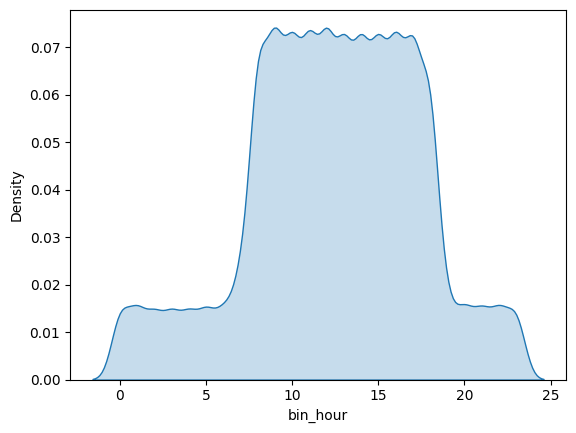

In [193]:
sns.kdeplot(time_data['bin_hour'], fill=True)
plt.show()

In [194]:
call_counts = time_data.groupby(['bin_hour', 'primary_call_reason']).size().reset_index(name='call_count')

heatmap_data = call_counts.pivot(index='primary_call_reason', columns='bin_hour', values='call_count').fillna(0)

fig = px.imshow(heatmap_data.values,
                labels=dict(x='Hour of the Day', y='Primary Call Reason', color='Number of Calls'),
                x=heatmap_data.columns,
                y=heatmap_data.index,
                color_continuous_scale='YlGnBu',
                text_auto=True)

fig.update_layout(title='Number of Calls by Primary Call Reason and Hour of the Day',
                  xaxis_title='Hour of the Day',
                  yaxis_title='Primary Call Reason',
                  xaxis=dict(tickmode='linear'),
                  yaxis=dict(autorange='reversed'),
                  width=1000)
fig.show()